In [2]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
import joblib
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# load in time series data and keep wanted variables 
vax = pd.read_csv('vaccinations.csv')
vax = vax[['date', 'location_key', 'new_persons_vaccinated', 'cumulative_persons_vaccinated']]

epi = pd.read_csv('epidemiology.csv')
epi = epi[['date', 'location_key', 'new_deceased', 'new_confirmed', 'cumulative_confirmed', 
           'cumulative_deceased']]

gov_response = pd.read_csv('oxford-government-response.csv')

In [4]:
# load in general info data
health = pd.read_csv('health.csv')
health = health[['location_key', 'life_expectancy', 'hospital_beds_per_1000', 'nurses_per_1000', 
                 'physicians_per_1000', 'health_expenditure_usd']]

econ = pd.read_csv('economy.csv')

demo = pd.read_csv('demographics.csv')
demo = demo[['population', 'location_key', 'population_density', 'human_development_index']]

#### Take a look at each dataset

In [5]:
vax.head()

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated
0,2021-01-25,AD,NaN,576.0
1,2021-02-01,AD,460.0,1036.0
2,2021-02-10,AD,255.0,1291.0
3,2021-02-12,AD,331.0,1622.0
4,2021-02-19,AD,519.0,2141.0


In [6]:
health.head()

,location_key,life_expectancy,hospital_beds_per_1000,nurses_per_1000,physicians_per_1000,health_expenditure_usd
0,AD,NaN,NaN,4.0128,3.3333,4040.786621
1,AE,77.814,NaN,5.7271,2.5278,1357.017456
2,AF,64.486,0.5,0.1755,0.2782,67.122650
3,AG,76.885,NaN,4.5171,2.9560,673.859680
4,AL,78.900,NaN,3.6495,1.2164,NaN


In [7]:
econ.head()

,location_key,gdp_usd,gdp_per_capita_usd,human_capital_index
0,AD,3.154058e+09,40886.0,NaN
1,AE,4.211423e+11,43103.0,0.659
2,AF,1.910135e+10,502.0,0.389
3,AG,1.727759e+09,17790.0,NaN
4,AL,1.527808e+10,5352.0,0.621


In [8]:
demo.head()

,population,location_key,population_density,human_development_index
0,77265.0,AD,164.394,0.858
1,9890400.0,AE,118.306,0.863
2,38928341.0,AF,59.627,0.498
3,1509183.0,AF_BAL,NaN,NaN
4,495557.0,AF_BAM,NaN,NaN


In [9]:
gov_response.tail()

,date,location_key,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,...,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
303964,2022-07-04,ZW,1.0,1.0,1.0,3.0,0.0,2.0,0.0,1.0,...,NaN,NaN,2.0,3.0,1.0,NaN,0.0,3.0,5.0,42.59
303965,2022-07-05,ZW,1.0,1.0,1.0,3.0,0.0,2.0,0.0,1.0,...,NaN,NaN,2.0,3.0,1.0,NaN,0.0,3.0,5.0,42.59
303966,2022-07-06,ZW,1.0,1.0,1.0,3.0,0.0,2.0,0.0,1.0,...,NaN,NaN,2.0,3.0,1.0,NaN,0.0,3.0,5.0,42.59
303967,2022-07-07,ZW,1.0,1.0,1.0,3.0,0.0,2.0,0.0,1.0,...,NaN,NaN,2.0,3.0,1.0,NaN,0.0,3.0,5.0,42.59
303968,2022-07-08,ZW,1.0,1.0,1.0,3.0,0.0,2.0,0.0,1.0,...,NaN,NaN,2.0,3.0,1.0,NaN,0.0,3.0,5.0,42.59


In [10]:
epi.tail()

,date,location_key,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased
12525820,2022-09-09,ZW,0.0,11.0,256870.0,5596.0
12525821,2022-09-10,ZW,0.0,18.0,256888.0,5596.0
12525822,2022-09-11,ZW,0.0,0.0,256888.0,5596.0
12525823,2022-09-12,ZW,0.0,51.0,256939.0,5596.0
12525824,2022-09-13,ZW,0.0,0.0,256939.0,5596.0


### Make one dataset for cumulative information on all of the locations. 
- One row for each location.

In [11]:
# merge factors (not vax, epi, or response yet because it has time series data and others are not)
merged_factors = pd.merge(pd.merge(health, econ, on='location_key', how='inner'), demo, 
                          on='location_key', how='inner')

In [12]:
merged_factors.head()

,location_key,life_expectancy,hospital_beds_per_1000,nurses_per_1000,physicians_per_1000,health_expenditure_usd,gdp_usd,gdp_per_capita_usd,human_capital_index,population,population_density,human_development_index
0,AD,NaN,NaN,4.0128,3.3333,4040.786621,3.154058e+09,40886.0,NaN,77265.0,164.394,0.858
1,AE,77.814,NaN,5.7271,2.5278,1357.017456,4.211423e+11,43103.0,0.659,9890400.0,118.306,0.863
2,AF,64.486,0.5,0.1755,0.2782,67.122650,1.910135e+10,502.0,0.389,38928341.0,59.627,0.498
3,AG,76.885,NaN,4.5171,2.9560,673.859680,1.727759e+09,17790.0,NaN,97928.0,222.564,0.780
4,AL,78.900,NaN,3.6495,1.2164,NaN,1.527808e+10,5352.0,0.621,2862427.0,99.600,0.764


#### Condense the time-series datasets so it is one row for each location 
- Then merge with the other cumulative data

In [13]:
# Group the vax data by location_key
grouped_data = vax.groupby('location_key')

# Initialize lists to store results
country_names = []
vax_per_day = []
total_vax = []

# Calculate the average vaccination rate for each country
for name, group in grouped_data:
    average_per_day = group['new_persons_vaccinated'].mean()
    total_vaccinated = group['new_persons_vaccinated'].sum()
    
    # add country name and vaccination rates to the lists initialized outside the loop
    country_names.append(name)
    vax_per_day.append(average_per_day)
    total_vax.append(total_vaccinated)

# Create a new DataFrame and add the results from the two lists
vax_rate_df = pd.DataFrame({'location_key': country_names, 
                          'vaccinations_per_day': vax_per_day,
                           'total_vaccinations': total_vax})

In [14]:
# Group the epi data by location_key
grouped_data = epi.groupby('location_key')

# Initialize lists to store results
country_names = []
death_per_day = []
total_death = []
confirmed_per_day = []
total_confirmed = []

# Calculate the average vaccination rate for each country
for name, group in grouped_data:
    average_death_per_day = group['new_deceased'].mean()
    death_sum = group['new_deceased'].sum()
    
    average_confirmed_per_day = group['new_confirmed'].mean()
    confirmed_sum = group['new_confirmed'].sum()
    
    # add country name and epi rates to the lists initialized outside the loop
    country_names.append(name)
    death_per_day.append(average_death_per_day)
    total_death.append(death_sum)
    confirmed_per_day.append(average_confirmed_per_day)
    total_confirmed.append(confirmed_sum)

# Create a new DataFrame and add the results from the two lists
epi_rate_df = pd.DataFrame({'location_key': country_names, 
                            'death_per_day': death_per_day,
                           'total_death': total_death,
                           'confirmed_per_day': confirmed_per_day,
                           'total_confirmed': total_confirmed,
                           })

In [15]:
# Group the response data by location_key
grouped_data = gov_response.groupby('location_key')

# Initialize lists to store results
country_names = []
stringency_index = []

# Calculate the average stringency index for each country
for name, group in grouped_data:
    avg_string_ind = group['stringency_index'].mean()
    
    # add country name and vaccination rates to the lists initialized outside the loop
    country_names.append(name)
    stringency_index.append(avg_string_ind)

# Create a new DF and add the results from the two lists
response_rate_df = pd.DataFrame({'location_key': country_names, 
                          'avg_stringency_index': stringency_index})

In [16]:
# merge epi, vax, and response data
epi_vax_response_totals = pd.merge(pd.merge(epi_rate_df, vax_rate_df, on='location_key', how='inner'),
                          response_rate_df, on='location_key', how='inner')

In [17]:
epi_vax_response_totals.head()

,location_key,death_per_day,total_death,confirmed_per_day,total_confirmed,vaccinations_per_day,total_vaccinations,avg_stringency_index
0,AD,0.157042,155.0,46.754813,46147.0,1081.452830,57317.0,40.313651
1,AE,2.372847,2342.0,1034.641337,1021191.0,24675.258760,9154521.0,49.538935
2,AF,7.893617,7791.0,199.253293,196663.0,152495.549296,10827184.0,30.769232
3,AL,3.633232,3586.0,334.497467,330149.0,5021.255639,1335654.0,48.896938
4,AO,1.942249,1917.0,104.489362,103131.0,184686.103896,14220830.0,56.860295


In [18]:
# merge vaccination rate data withe already merged factors. Vaccination will be more of response var
location_totals = pd.merge(merged_factors, epi_vax_response_totals, on='location_key', how='inner')

In [19]:
# check out new dataset
location_totals.head()

,location_key,life_expectancy,hospital_beds_per_1000,nurses_per_1000,physicians_per_1000,health_expenditure_usd,gdp_usd,gdp_per_capita_usd,human_capital_index,population,population_density,human_development_index,death_per_day,total_death,confirmed_per_day,total_confirmed,vaccinations_per_day,total_vaccinations,avg_stringency_index
0,AD,NaN,NaN,4.0128,3.3333,4040.786621,3.154058e+09,40886.0,NaN,77265.0,164.394,0.858,0.157042,155.0,46.754813,46147.0,1081.452830,57317.0,40.313651
1,AE,77.814,NaN,5.7271,2.5278,1357.017456,4.211423e+11,43103.0,0.659,9890400.0,118.306,0.863,2.372847,2342.0,1034.641337,1021191.0,24675.258760,9154521.0,49.538935
2,AF,64.486,0.5,0.1755,0.2782,67.122650,1.910135e+10,502.0,0.389,38928341.0,59.627,0.498,7.893617,7791.0,199.253293,196663.0,152495.549296,10827184.0,30.769232
3,AL,78.900,NaN,3.6495,1.2164,NaN,1.527808e+10,5352.0,0.621,2862427.0,99.600,0.764,3.633232,3586.0,334.497467,330149.0,5021.255639,1335654.0,48.896938
4,AO,60.782,NaN,0.4075,0.2146,114.459641,9.463542e+10,2973.0,0.361,32866267.0,26.363,0.581,1.942249,1917.0,104.489362,103131.0,184686.103896,14220830.0,56.860295


In [20]:
# make vaccinations per 1000 people so it can be compared across countries 
location_totals['vaccinations_per_day_per_1000'] = (location_totals['vaccinations_per_day'] / 
                                                    location_totals['population']) * 1000
location_totals['total_vaccinations_per_1000'] = (location_totals['total_vaccinations'] / 
                                                    location_totals['population']) * 1000

In [21]:
location_totals.head()

,location_key,life_expectancy,hospital_beds_per_1000,nurses_per_1000,physicians_per_1000,health_expenditure_usd,gdp_usd,gdp_per_capita_usd,human_capital_index,population,...,human_development_index,death_per_day,total_death,confirmed_per_day,total_confirmed,vaccinations_per_day,total_vaccinations,avg_stringency_index,vaccinations_per_day_per_1000,total_vaccinations_per_1000
0,AD,NaN,NaN,4.0128,3.3333,4040.786621,3.154058e+09,40886.0,NaN,77265.0,...,0.858,0.157042,155.0,46.754813,46147.0,1081.452830,57317.0,40.313651,13.996672,741.823594
1,AE,77.814,NaN,5.7271,2.5278,1357.017456,4.211423e+11,43103.0,0.659,9890400.0,...,0.863,2.372847,2342.0,1034.641337,1021191.0,24675.258760,9154521.0,49.538935,2.494870,925.596639
2,AF,64.486,0.5,0.1755,0.2782,67.122650,1.910135e+10,502.0,0.389,38928341.0,...,0.498,7.893617,7791.0,199.253293,196663.0,152495.549296,10827184.0,30.769232,3.917340,278.131144
3,AL,78.900,NaN,3.6495,1.2164,NaN,1.527808e+10,5352.0,0.621,2862427.0,...,0.764,3.633232,3586.0,334.497467,330149.0,5021.255639,1335654.0,48.896938,1.754195,466.615917
4,AO,60.782,NaN,0.4075,0.2146,114.459641,9.463542e+10,2973.0,0.361,32866267.0,...,0.581,1.942249,1917.0,104.489362,103131.0,184686.103896,14220830.0,56.860295,5.619321,432.687716


#### Clean the data:

In [22]:
# Check how many missing values are in each column
location_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   location_key                   187 non-null    object 
 1   life_expectancy                185 non-null    float64
 2   hospital_beds_per_1000         24 non-null     float64
 3   nurses_per_1000                158 non-null    float64
 4   physicians_per_1000            148 non-null    float64
 5   health_expenditure_usd         167 non-null    float64
 6   gdp_usd                        187 non-null    float64
 7   gdp_per_capita_usd             179 non-null    float64
 8   human_capital_index            151 non-null    float64
 9   population                     187 non-null    float64
 10  population_density             179 non-null    float64
 11  human_development_index        167 non-null    float64
 12  death_per_day                  187 non-null    flo

Hospital beds per 1000 has the least amount of information by far, so it makes sense to just remove it. Otherwise, the columns are mostly full. 

In [23]:
# drop hospital_beds_per_1000
location_totals = location_totals.drop('hospital_beds_per_1000', axis=1)

Next, I want to drop rows that have more than 5 missing values.

In [24]:
# see how many rows should be dropped
missing_values_count = location_totals.isna().sum(axis=1)
rows_with_4_missing_values = (missing_values_count >= 5).sum()
rows_with_4_missing_values

15

There are 15 rows with 5 or more missing values. All of these should be dropped.

In [25]:
# drop rows with 5 or more missing values 
location_totals = location_totals.dropna(thresh=len(location_totals.columns) - 4)

Now all rows have less than 5 missing values. To fill in the rest of the missing values, I will input the median of that column. 

In [26]:
numerics = location_totals.select_dtypes(include=[np.number])
location_totals[numerics.columns] = location_totals[numerics.columns].fillna(numerics.median())

In [27]:
location_totals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 0 to 186
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   location_key                   172 non-null    object 
 1   life_expectancy                172 non-null    float64
 2   nurses_per_1000                172 non-null    float64
 3   physicians_per_1000            172 non-null    float64
 4   health_expenditure_usd         172 non-null    float64
 5   gdp_usd                        172 non-null    float64
 6   gdp_per_capita_usd             172 non-null    float64
 7   human_capital_index            172 non-null    float64
 8   population                     172 non-null    float64
 9   population_density             172 non-null    float64
 10  human_development_index        172 non-null    float64
 11  death_per_day                  172 non-null    float64
 12  total_death                    172 non-null    float64


#### Export the dataset to a csv: 

In [28]:
location_totals.to_csv('location_totals.csv')

### The time-series data will be merged in SQLite:

In [29]:
# output a db file for vax to use in SQLite
conn = sqlite3.connect('location_series_data.db')
vax.to_sql('vax', conn, if_exists='replace', index=False)
epi.to_sql('epi', conn, if_exists='replace', index=False)
gov_response.to_sql('response', conn, if_exists='replace', index=False)
conn.close()

The data has been merged and worked with in sql, so I will read the resulting set back into here

In [30]:
location_series = pd.read_csv('merged_data.csv', low_memory=False)

In [31]:
location_series.head()

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased,stringency_index
0,2021-01-25,AD,NaN,576.0,0.0,42.0,9638.0,97.0,52.78
1,2021-02-01,AD,460.0,1036.0,1.0,45.0,10017.0,102.0,55.56
2,2021-02-10,AD,255.0,1291.0,0.0,39.0,10391.0,106.0,55.56
3,2021-02-12,AD,331.0,1622.0,1.0,36.0,10463.0,107.0,55.56
4,2021-02-19,AD,519.0,2141.0,0.0,27.0,10672.0,107.0,55.56


Check datatypes to ensure they are all as expected:

In [32]:
location_series.dtypes

date                             object
location_key                     object
new_persons_vaccinated           object
cumulative_persons_vaccinated    object
new_deceased                     object
new_confirmed                    object
cumulative_confirmed             object
cumulative_deceased              object
stringency_index                 object
dtype: object

All variables were treated as strings so change as needed

In [33]:
# Some weird rows copied where the cells are just the column name so remove those
location_series = location_series[location_series['date'] != 'date']

In [34]:
location_series['date'] = pd.to_datetime(location_series['date'])
int_columns = ['new_persons_vaccinated', 'cumulative_persons_vaccinated', 'new_deceased', 
               'new_confirmed', 'cumulative_confirmed', 'cumulative_deceased']
float_columns = ['stringency_index']
location_series[int_columns] = location_series[int_columns].apply(pd.to_numeric, errors='coerce', downcast='integer')
location_series[float_columns] = location_series[float_columns].apply(pd.to_numeric, errors='coerce')

In [35]:
location_series.dtypes

date                             datetime64[ns]
location_key                             object
new_persons_vaccinated                  float64
cumulative_persons_vaccinated           float64
new_deceased                            float64
new_confirmed                           float64
cumulative_confirmed                    float64
cumulative_deceased                     float64
stringency_index                        float64
dtype: object

All the datatypes look right now.

In [36]:
location_series.head(5)

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased,stringency_index
0,2021-01-25,AD,NaN,576.0,0.0,42.0,9638.0,97.0,52.78
1,2021-02-01,AD,460.0,1036.0,1.0,45.0,10017.0,102.0,55.56
2,2021-02-10,AD,255.0,1291.0,0.0,39.0,10391.0,106.0,55.56
3,2021-02-12,AD,331.0,1622.0,1.0,36.0,10463.0,107.0,55.56
4,2021-02-19,AD,519.0,2141.0,0.0,27.0,10672.0,107.0,55.56


In [37]:
location_series.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220284 entries, 0 to 220285
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   date                           220284 non-null  datetime64[ns]
 1   location_key                   220284 non-null  object        
 2   new_persons_vaccinated         200407 non-null  float64       
 3   cumulative_persons_vaccinated  195518 non-null  float64       
 4   new_deceased                   220074 non-null  float64       
 5   new_confirmed                  220156 non-null  float64       
 6   cumulative_confirmed           220158 non-null  float64       
 7   cumulative_deceased            220118 non-null  float64       
 8   stringency_index               219018 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 16.8+ MB


I need to see what some of these null values are by investigating one location.

In [38]:
location_series[location_series['location_key'] == 'AD']

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased,stringency_index
0,2021-01-25,AD,NaN,576.0,0.0,42.0,9638.0,97.0,52.78
1,2021-02-01,AD,460.0,1036.0,1.0,45.0,10017.0,102.0,55.56
2,2021-02-10,AD,255.0,1291.0,0.0,39.0,10391.0,106.0,55.56
3,2021-02-12,AD,331.0,1622.0,1.0,36.0,10463.0,107.0,55.56
4,2021-02-19,AD,519.0,2141.0,0.0,27.0,10672.0,107.0,55.56
...,...,...,...,...,...,...,...,...,...
110188,2022-05-22,AD,4.0,57878.0,0.0,0.0,42572.0,153.0,8.33
110189,2022-05-29,AD,2.0,57880.0,0.0,0.0,42894.0,153.0,8.33
110190,2022-06-12,AD,3.0,57883.0,0.0,0.0,43224.0,153.0,8.33
220284,2021-01-25,AD,NaN,576.0,0.0,42.0,9638.0,97.0,52.78


I see that there are some duplicate rows. I will drop them. 

In [39]:
location_series.drop_duplicates(inplace=True)

In [40]:
location_series[location_series['location_key'] == 'AD']

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased,stringency_index
0,2021-01-25,AD,NaN,576.0,0.0,42.0,9638.0,97.0,52.78
1,2021-02-01,AD,460.0,1036.0,1.0,45.0,10017.0,102.0,55.56
2,2021-02-10,AD,255.0,1291.0,0.0,39.0,10391.0,106.0,55.56
3,2021-02-12,AD,331.0,1622.0,1.0,36.0,10463.0,107.0,55.56
4,2021-02-19,AD,519.0,2141.0,0.0,27.0,10672.0,107.0,55.56
5,2021-02-24,AD,249.0,2390.0,0.0,24.0,10799.0,110.0,55.56
6,2021-02-26,AD,0.0,NaN,0.0,27.0,10849.0,110.0,55.56
7,2021-03-08,AD,49.0,2439.0,0.0,20.0,11089.0,112.0,55.56
8,2021-03-10,AD,1211.0,3650.0,0.0,69.0,11199.0,112.0,55.56
9,2021-03-15,AD,3448.0,7098.0,0.0,30.0,11319.0,113.0,55.56


If cumulative_persons_vaccinated is null, it looks like a mistake, so I will drop those rows. 

In [41]:
location_series.dropna(subset=['cumulative_persons_vaccinated'], inplace=True)

The same should apply for other cumulative columns, so I will do the same for those: 

In [42]:
location_series.dropna(subset=['cumulative_persons_vaccinated'], inplace=True)
location_series.dropna(subset=['cumulative_confirmed'], inplace=True)
location_series.dropna(subset=['cumulative_deceased'], inplace=True)

In [43]:
location_series.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97620 entries, 0 to 110140
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           97620 non-null  datetime64[ns]
 1   location_key                   97620 non-null  object        
 2   new_persons_vaccinated         97319 non-null  float64       
 3   cumulative_persons_vaccinated  97620 non-null  float64       
 4   new_deceased                   97598 non-null  float64       
 5   new_confirmed                  97619 non-null  float64       
 6   cumulative_confirmed           97620 non-null  float64       
 7   cumulative_deceased            97620 non-null  float64       
 8   stringency_index               96988 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 7.4+ MB


There are only a small null values left, so I think it makes sense to just drop them. 

In [44]:
location_series.dropna(inplace=True)

In [45]:
location_series.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96668 entries, 1 to 110140
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           96668 non-null  datetime64[ns]
 1   location_key                   96668 non-null  object        
 2   new_persons_vaccinated         96668 non-null  float64       
 3   cumulative_persons_vaccinated  96668 non-null  float64       
 4   new_deceased                   96668 non-null  float64       
 5   new_confirmed                  96668 non-null  float64       
 6   cumulative_confirmed           96668 non-null  float64       
 7   cumulative_deceased            96668 non-null  float64       
 8   stringency_index               96668 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 7.4+ MB


#### Export series data to csv:

In [46]:
location_series.to_csv('location_series.csv')

#### Upon inspection, this dataset includes US cities
- I will extract the cities into a different dataset so I have one for just countries and one for just cities.

In [47]:
us_locations = location_series[location_series['location_key'].str.startswith('US_')]
us_locations['location_key'] = us_locations['location_key'].str.replace('US_', '')

/var/folders/4l/944cj3pd4hn2cm3hpy927z600000gn/T/ipykernel_1936/1707419943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_locations['location_key'] = us_locations['location_key'].str.replace('US_', '')


In [48]:
us_locations.head()

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased,stringency_index
80022,2021-01-13,AK,2055.0,24541.0,1.0,330.0,49801.0,307.0,61.57
80023,2021-01-14,AK,10967.0,35508.0,2.0,291.0,50092.0,309.0,61.57
80024,2021-01-15,AK,4038.0,39546.0,0.0,194.0,50286.0,309.0,61.57
80025,2021-01-19,AK,15888.0,55434.0,1.0,162.0,50980.0,313.0,57.87
80026,2021-01-20,AK,1477.0,56911.0,0.0,198.0,51178.0,313.0,57.87


### Add the full name of each location to match to the key in all 3 datasets
- For easy interpretability

In [49]:
# Read in timezones csv with country names to match with countries
country_names = pd.read_csv('timezones.csv')
country_names = country_names[['CountryCode', 'CountryName']]
country_names.rename(columns={'CountryCode' : 'location_key'}, inplace=True)

# Read in CDC city names to match with cities
city_names = pd.read_csv('us_cdc_locations.csv')
city_names.rename(columns={'key' : 'location_key', 'state_or_territory_name' : 'City/Territory'
                          }, inplace=True)

In [50]:
city_names.head()

,location_key,City/Territory
0,AK,Alaska
1,AL,Alabama
2,AR,Arkansas
3,AS,American Samoa
4,AZ,Arizona


In [51]:
location_series = pd.merge(country_names, location_series, on='location_key', how='inner')

In [52]:
location_series.drop_duplicates(inplace=True)

In [53]:
location_series.head()

,location_key,CountryName,date,new_persons_vaccinated,cumulative_persons_vaccinated,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased,stringency_index
0,AD,Andorra,2021-02-01,460.0,1036.0,1.0,45.0,10017.0,102.0,55.56
1,AD,Andorra,2021-02-10,255.0,1291.0,0.0,39.0,10391.0,106.0,55.56
2,AD,Andorra,2021-02-12,331.0,1622.0,1.0,36.0,10463.0,107.0,55.56
3,AD,Andorra,2021-02-19,519.0,2141.0,0.0,27.0,10672.0,107.0,55.56
4,AD,Andorra,2021-02-24,249.0,2390.0,0.0,24.0,10799.0,110.0,55.56


In [54]:
location_totals = pd.merge(country_names, location_totals, on='location_key', how='inner')

In [55]:
location_totals = location_totals.drop_duplicates()

In [56]:
location_totals.head()

,location_key,CountryName,life_expectancy,nurses_per_1000,physicians_per_1000,health_expenditure_usd,gdp_usd,gdp_per_capita_usd,human_capital_index,population,...,human_development_index,death_per_day,total_death,confirmed_per_day,total_confirmed,vaccinations_per_day,total_vaccinations,avg_stringency_index,vaccinations_per_day_per_1000,total_vaccinations_per_1000
0,AD,Andorra,74.063,4.0128,3.3333,4040.786621,3.154058e+09,40886.0,0.576,77265.0,...,0.858,0.157042,155.0,46.754813,46147.0,1081.452830,57317.0,40.313651,13.996672,741.823594
1,AE,United Arab Emirates,77.814,5.7271,2.5278,1357.017456,4.211423e+11,43103.0,0.659,9890400.0,...,0.863,2.372847,2342.0,1034.641337,1021191.0,24675.258760,9154521.0,49.538935,2.494870,925.596639
2,AF,Afghanistan,64.486,0.1755,0.2782,67.122650,1.910135e+10,502.0,0.389,38928341.0,...,0.498,7.893617,7791.0,199.253293,196663.0,152495.549296,10827184.0,30.769232,3.917340,278.131144
3,AL,Albania,78.900,3.6495,1.2164,300.124817,1.527808e+10,5352.0,0.621,2862427.0,...,0.764,3.633232,3586.0,334.497467,330149.0,5021.255639,1335654.0,48.896938,1.754195,466.615917
4,AO,Angola,60.782,0.4075,0.2146,114.459641,9.463542e+10,2973.0,0.361,32866267.0,...,0.581,1.942249,1917.0,104.489362,103131.0,184686.103896,14220830.0,56.860295,5.619321,432.687716


In [57]:
us_locations = pd.merge(city_names, us_locations, on='location_key', how='inner')

In [58]:
us_locations.head()

,location_key,City/Territory,date,new_persons_vaccinated,cumulative_persons_vaccinated,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased,stringency_index
0,AK,Alaska,2021-01-13,2055.0,24541.0,1.0,330.0,49801.0,307.0,61.57
1,AK,Alaska,2021-01-14,10967.0,35508.0,2.0,291.0,50092.0,309.0,61.57
2,AK,Alaska,2021-01-15,4038.0,39546.0,0.0,194.0,50286.0,309.0,61.57
3,AK,Alaska,2021-01-19,15888.0,55434.0,1.0,162.0,50980.0,313.0,57.87
4,AK,Alaska,2021-01-20,1477.0,56911.0,0.0,198.0,51178.0,313.0,57.87


In [59]:
us_locations.to_csv('us_locations.csv')
location_totals.to_csv('location_totals.csv')
location_series.to_csv('location_series.csv')

## Exploratory Data Analysis
- A brief look at descriptive statistics and correlations
- Other team members are handling a lot of exploration elsewhere

#### Country time series data first:

In [60]:
# format so it shows values with 2 decimals
pd.options.display.float_format = '{:.2f}'.format
# get statistics
location_series.describe()

,date,new_persons_vaccinated,cumulative_persons_vaccinated,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased,stringency_index
count,43288,43288.00,43288.00,43288.00,43288.00,43288.00,43288.00,43288.00
mean,2021-10-07 02:02:17.054149120,106717.52,23916487.43,85.22,9363.96,2907228.91,47902.02,50.90
min,2020-12-07 00:00:00,-1106411.00,0.00,-36.00,-575.00,0.00,0.00,0.00
25%,2021-06-06 00:00:00,995.00,673834.25,1.00,116.00,123137.25,1333.00,38.89
50%,2021-09-30 00:00:00,7223.00,3787808.00,8.00,906.00,547182.50,7565.00,51.39
75%,2022-02-06 00:00:00,40217.00,14739445.50,45.00,5092.00,2095149.25,30180.25,65.28
max,2022-07-26 00:00:00,450500000.00,1294045000.00,11447.00,1235521.00,85573600.00,976254.00,97.22
std,NaN,2289902.61,89453760.09,295.75,33958.13,7862667.67,117720.92,19.15


Make a correlation matrix heatmap: 

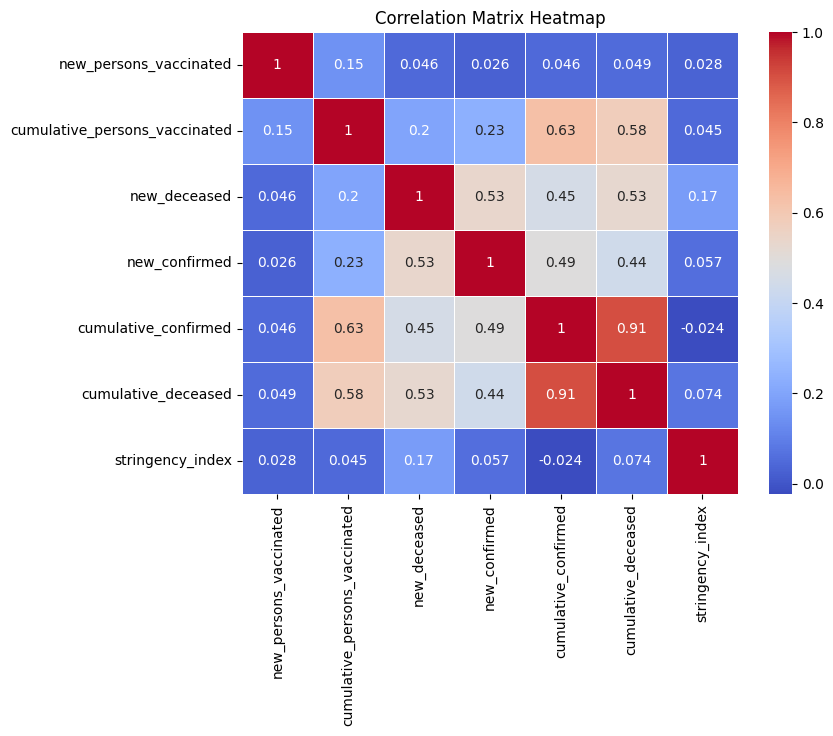

In [61]:
# Generate the correlation matrix for numeric variables
numeric_columns = ['new_persons_vaccinated', 'cumulative_persons_vaccinated', 'new_deceased', 
               'new_confirmed', 'cumulative_confirmed', 'cumulative_deceased', 'stringency_index']
corr_matrix = location_series[numeric_columns].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Some notable correlations:
- cumulative_deceased and cumulative_persons_vaccinated
- cumulative_confirmed and cumulative_persons_vaccinated
- new_confirmed and new_deceased

#### Country totals data now:

In [62]:
location_totals.head()

,location_key,CountryName,life_expectancy,nurses_per_1000,physicians_per_1000,health_expenditure_usd,gdp_usd,gdp_per_capita_usd,human_capital_index,population,...,human_development_index,death_per_day,total_death,confirmed_per_day,total_confirmed,vaccinations_per_day,total_vaccinations,avg_stringency_index,vaccinations_per_day_per_1000,total_vaccinations_per_1000
0,AD,Andorra,74.06,4.01,3.33,4040.79,3154057987.00,40886.00,0.58,77265.00,...,0.86,0.16,155.00,46.75,46147.00,1081.45,57317.00,40.31,14.00,741.82
1,AE,United Arab Emirates,77.81,5.73,2.53,1357.02,421142267937.00,43103.00,0.66,9890400.00,...,0.86,2.37,2342.00,1034.64,1021191.00,24675.26,9154521.00,49.54,2.49,925.60
2,AF,Afghanistan,64.49,0.18,0.28,67.12,19101353832.00,502.00,0.39,38928341.00,...,0.50,7.89,7791.00,199.25,196663.00,152495.55,10827184.00,30.77,3.92,278.13
3,AL,Albania,78.90,3.65,1.22,300.12,15278077446.00,5352.00,0.62,2862427.00,...,0.76,3.63,3586.00,334.50,330149.00,5021.26,1335654.00,48.90,1.75,466.62
4,AO,Angola,60.78,0.41,0.21,114.46,94635415869.00,2973.00,0.36,32866267.00,...,0.58,1.94,1917.00,104.49,103131.00,184686.10,14220830.00,56.86,5.62,432.69


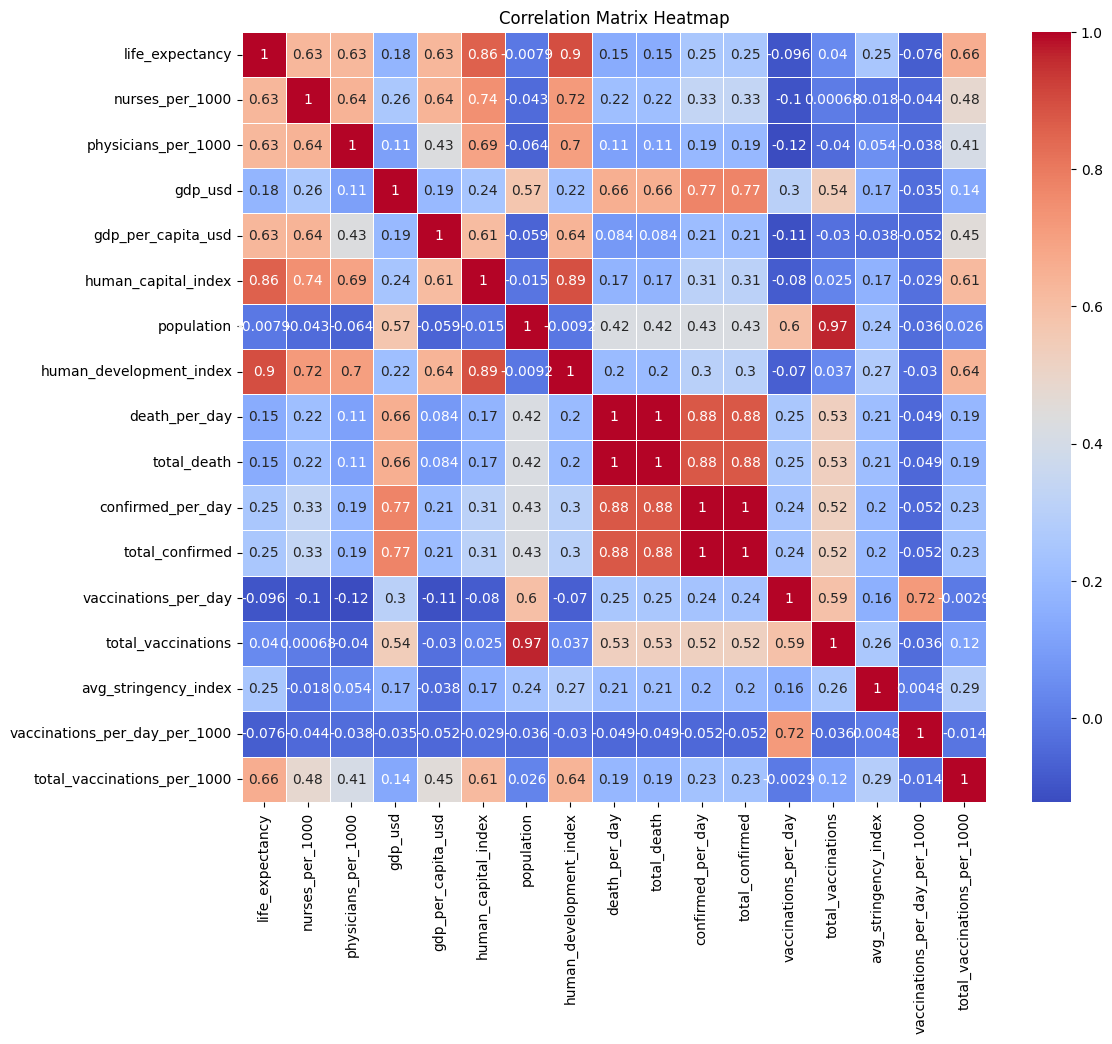

In [63]:
# Generate the correlation matrix for numeric variables
numeric_columns = ['life_expectancy', 'nurses_per_1000', 'physicians_per_1000', 
               'gdp_usd', 'gdp_per_capita_usd', 'human_capital_index', 'population', 'human_development_index',
                  'death_per_day', 'total_death', 'confirmed_per_day', 'total_confirmed', 'vaccinations_per_day',
                  'total_vaccinations', 'avg_stringency_index', 'vaccinations_per_day_per_1000', 
                   'total_vaccinations_per_1000']
corr_matrix = location_totals[numeric_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Make scatterplots for vaccinations against some correlated variables:

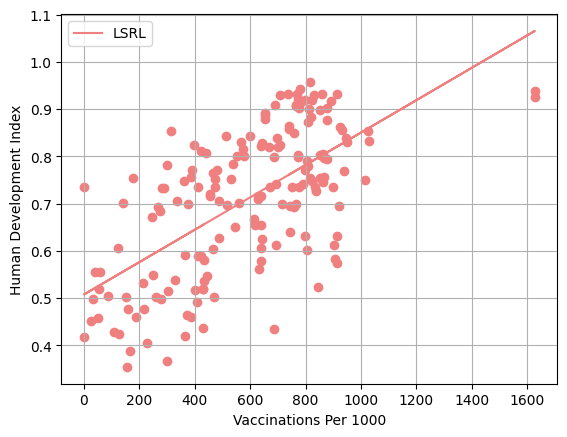

In [64]:
# Create scatter plot for the test group
plt.scatter(location_totals['total_vaccinations_per_1000'], location_totals['human_development_index'], color='lightcoral')

# Calculate LSRL for the test group
coeffs = np.polyfit(location_totals['total_vaccinations_per_1000'], location_totals['human_development_index'], 1)
line = np.poly1d(coeffs)
x = np.array(location_totals['total_vaccinations_per_1000'])
y = line(x)

# Plot LSRLs
plt.plot(x, y, color='lightcoral', linestyle='-', label='LSRL')

# Add labels and legend
plt.xlabel('Vaccinations Per 1000')
plt.ylabel('Human Development Index')
plt.legend()

plt.grid(True)
plt.show()

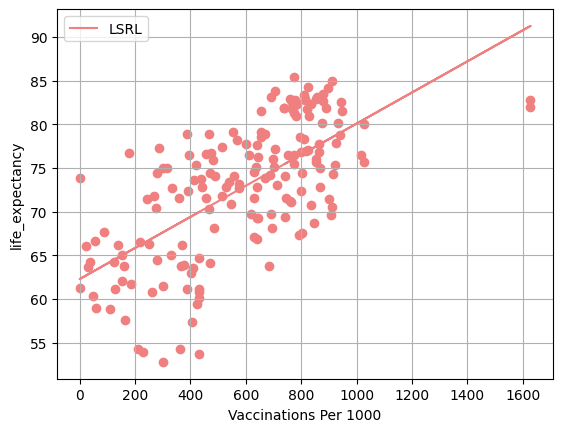

In [65]:
# Create scatter plot for the test group
plt.scatter(location_totals['total_vaccinations_per_1000'], location_totals['life_expectancy'], color='lightcoral')

# Calculate LSRL for the test group
coeffs = np.polyfit(location_totals['total_vaccinations_per_1000'], location_totals['life_expectancy'], 1)
line = np.poly1d(coeffs)
x = np.array(location_totals['total_vaccinations_per_1000'])
y = line(x)

# Plot LSRLs
plt.plot(x, y, color='lightcoral', linestyle='-', label='LSRL')

# Add labels and legend
plt.xlabel('Vaccinations Per 1000')
plt.ylabel('life_expectancy')
plt.legend()

plt.grid(True)
plt.show()

### Gradient Boosted Regression: Predicting Total Vaccinations Per 1000

In [66]:
# function to split into x and y variables and scale x variables 
def scale_and_split(data, features, response_var):
    x = data[features]
    y = data[response_var]
    sc = StandardScaler()
    x_scaled = sc.fit_transform(x)
    return x_scaled,y

In [67]:
features = ['life_expectancy', 'nurses_per_1000', 'physicians_per_1000', 
               'gdp_usd', 'gdp_per_capita_usd', 'human_capital_index', 'population', 'human_development_index',
                  'death_per_day', 'total_death', 'confirmed_per_day', 'total_confirmed', 'avg_stringency_index']
response = 'total_vaccinations_per_1000'

x,y = scale_and_split(location_totals, features, response)

In [68]:
def fit_reg(x, y):
    # Initialize regressor model
    reg = ensemble.GradientBoostingRegressor()
    reg.fit(x, y)
    
    # Perform k-fold cross-validation and predict the target variable
    predicted = cross_val_predict(reg, x, y, cv=5)
    return predicted

In [69]:
def score(y, predicted):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predicted)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(y, predicted, squared=False)  # Pass squared=False to get RMSE directly
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predicted)
    
    # Calculate R² score
    r2 = r2_score(y, predicted)

    return mse, rmse, mae, r2

In [70]:
predicted = fit_reg(x, y)
mse, rmse, mae, r2 = score(y, predicted)

In [71]:
print(f"MSE: {mse}\nRMSE: {rmse}\nMAE {mae}\nR^2: {r2}")

MSE: 52596.644280075074
RMSE: 229.33958288981663
MAE 177.51677663171196
R^2: 0.35051918070019294


#### Get feature importances from the model to optimize feature selection

In [72]:
# Get feature importances
feature_importances = reg.feature_importances_
# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df
# Visualize 
plt.figure(figsize=(20, 10))
plt.bar(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

NameError: name 'reg' is not defined

In [ ]:
# rerun the model with selected features

features = ['life_expectancy', 'physicians_per_1000', 
               'gdp_usd', 'gdp_per_capita_usd', 'human_capital_index', 'population', 'human_development_index',
                  'death_per_day', 'avg_stringency_index']
response = 'total_vaccinations_per_1000'

x,y = scale_and_split(location_totals, features, response)
predicted = fit_reg(x, y)
mse, rmse, mae, r2 = score(y, predicted)

In [ ]:
print(f"MSE: {mse}\nRMSE: {rmse}\nMAE {mae}\nR^2: {r2}")

MSE: 52279.37032953934
RMSE: 228.64682444665473
MAE 179.02487524792397
R^2: 0.3544369847380162


Did not improve much ... can optimize parameters further, but I am going to switch over to some time series analysis now because I have some ideas for identifying trends and the applicability of such analysis. 

### Process time series data more:

In [ ]:
location_series.columns

Index(['location_key', 'CountryName', 'date', 'new_persons_vaccinated',
       'cumulative_persons_vaccinated', 'new_deceased', 'new_confirmed',
       'cumulative_confirmed', 'cumulative_deceased', 'stringency_index'],
      dtype='object')

In [ ]:
us_locations.columns

Index(['location_key', 'City/Territory', 'date', 'new_persons_vaccinated',
       'cumulative_persons_vaccinated', 'new_deceased', 'new_confirmed',
       'cumulative_confirmed', 'cumulative_deceased', 'stringency_index'],
      dtype='object')

#### Looking at the variables in the time series data, I want some more information, so I will add more about government response

In [73]:
us_response = gov_response[gov_response['location_key'] == 'US']

In [74]:
# extract just US time series data to analyze
us_series = location_series[location_series['location_key'] == 'US']

In [75]:
us_series = pd.merge(us_series, us_response, on='location_key', how='inner')

In [76]:
us_series['date'] = us_series['date_x']
us_series['stringency_index'] = us_series['stringency_index_y']
us_series.drop(columns=['date_x', 'date_y', 'stringency_index_y', 'stringency_index_x'], inplace=True)

In [77]:
us_series.to_csv('us_series.csv')

#### Import another dataset containing mobility information to merge with us_series:

In [78]:
mobility = pd.read_csv('mobility.csv')

In [79]:
mobility.head()

,date,location_key,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
0,2020-02-15,AE,0.00,4.00,5.00,0.00,2.00,1.00
1,2020-02-16,AE,1.00,4.00,4.00,1.00,2.00,1.00
2,2020-02-17,AE,-1.00,1.00,5.00,1.00,2.00,1.00
3,2020-02-18,AE,-2.00,1.00,5.00,0.00,2.00,1.00
4,2020-02-19,AE,-2.00,0.00,4.00,-1.00,2.00,1.00


In [80]:
us_mobility = mobility[mobility['location_key'] == 'US']

In [81]:
us_mobility.head()

,date,location_key,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
3845350,2020-02-15,US,6.00,2.00,15.00,3.00,2.00,-1.00
3845351,2020-02-16,US,7.00,1.00,16.00,2.00,0.00,-1.00
3845352,2020-02-17,US,6.00,0.00,28.00,-9.00,-24.00,5.00
3845353,2020-02-18,US,0.00,-1.00,6.00,1.00,0.00,1.00
3845354,2020-02-19,US,2.00,0.00,8.00,1.00,1.00,0.00


In [82]:
us_series = pd.read_csv('us_series.csv')

In [83]:
us_series1 = pd.merge(us_series, us_mobility, on='date', how='inner')

In [84]:
us_series1 = us_series1.drop(columns=['location_key_y'])

In [85]:
us_series = us_series1
us_series.head()

,Unnamed: 0,location_key_x,CountryName,new_persons_vaccinated,cumulative_persons_vaccinated,new_deceased,new_confirmed,cumulative_confirmed,cumulative_deceased,school_closing,...,facial_coverings,vaccination_policy,date,stringency_index,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
0,0,US,United States of America,30817.00,30817.00,2021.00,177830.00,16119805.00,287276.00,0.00,...,0.00,0.00,2020-12-13,0.00,-21.00,-8.00,-16.00,-35.00,-15.00,6.00
1,1,US,United States of America,30817.00,30817.00,2021.00,177830.00,16119805.00,287276.00,0.00,...,0.00,0.00,2020-12-13,0.00,-21.00,-8.00,-16.00,-35.00,-15.00,6.00
2,2,US,United States of America,30817.00,30817.00,2021.00,177830.00,16119805.00,287276.00,0.00,...,0.00,0.00,2020-12-13,0.00,-21.00,-8.00,-16.00,-35.00,-15.00,6.00
3,3,US,United States of America,30817.00,30817.00,2021.00,177830.00,16119805.00,287276.00,0.00,...,0.00,0.00,2020-12-13,0.00,-21.00,-8.00,-16.00,-35.00,-15.00,6.00
4,4,US,United States of America,30817.00,30817.00,2021.00,177830.00,16119805.00,287276.00,0.00,...,0.00,0.00,2020-12-13,0.00,-21.00,-8.00,-16.00,-35.00,-15.00,6.00


In [86]:
us_series.to_csv("us_series.csv")

#### All the information I want is in the dataset now, so I can start analyzing the time-series data
- Further analysis displayed in Vaccination_ARIMAX.ipynb notebook